### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *
from utillity_script_lr_schedulers import *

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
kfold_set = pd.read_csv('../input/cloud-data-split-v2/3-fold.csv')

X_train = kfold_set[kfold_set['fold_0'] == 'train']
X_val = kfold_set[kfold_set['fold_0'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])

display(X_train.head())

Compete set samples: 22184
Train samples:  3682
Validation samples:  1843


,image,Fish,Flower,Sugar,Gravel,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,fold_0,fold_1,fold_2
0,0011165.jpg,1,1,0,0,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN,train,validation,train
1,002be4f.jpg,1,1,1,0,233813 878 235213 878 236613 878 238010 881 23...,1339279 519 1340679 519 1342079 519 1343479 51...,NaN,67495 350 68895 350 70295 350 71695 350 73095 ...,train,validation,train
2,0031ae9.jpg,1,1,1,0,3510 690 4910 690 6310 690 7710 690 9110 690 1...,2047 703 3447 703 4847 703 6247 703 7647 703 9...,NaN,658170 388 659570 388 660970 388 662370 388 66...,train,train,validation
4,003994e.jpg,1,0,1,1,2367966 18 2367985 2 2367993 8 2368002 62 2369...,NaN,353317 416 354717 416 356117 416 357517 416 35...,28011 489 29411 489 30811 489 32211 489 33611 ...,train,validation,train
5,00498ec.jpg,0,0,0,1,NaN,NaN,326420 552 327820 552 329220 552 330620 552 33...,NaN,train,validation,train


# Model parameters

In [3]:
BACKBONE = 'efficientnetb0'
BATCH_SIZE = 16
EPOCHS_PT1 = 5
EPOCHS = 15
LEARNING_RATE = 10**(-1.8)
HEIGHT_PT1 = 256
WIDTH_PT1 = 384
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 7
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

model_path = '71-fold1_unet_%s_%sx%s.h5' % (BACKBONE, HEIGHT, WIDTH)
train_images_pt1_path = '../input/cloud-images-resized-256x384/train_images256x384/train_images/'
train_images_path = '../input/cloud-images-resized-320x480/train_images320x480/train_images/'

In [4]:
preprocessing = sm.get_preprocessing(BACKBONE)

augmentation_pt1 = albu.Compose([albu.OneOf([
                                  albu.HorizontalFlip(p=0.5),
                                  albu.VerticalFlip(p=0.5),
                                  albu.Flip(p=0.5),
                                  ], p=0.6),
                             albu.OneOf([
                                  albu.GridDistortion(p=0.5),
                                  albu.OpticalDistortion(p=0.2),
                                  albu.ElasticTransform(p=0.5),
                                  ], p=0.4),
                             albu.OneOf([
                                  albu.RandomContrast(p=0.5),
                                  albu.RandomBrightnessContrast(p=0.5),
                                  ], p=0.5),
                             albu.OneOf([
                                  albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, 
                                                        shift_limit=0.1, border_mode=0, p=0.5),
                                  ], p=0.3),
                            ])

augmentation = albu.Compose([albu.OneOf([
                                  albu.HorizontalFlip(p=0.5),
                                  albu.VerticalFlip(p=0.5),
                                  albu.Flip(p=0.5),
                                  ], p=0.6),
                             albu.OneOf([
                                  albu.GridDistortion(p=0.5),
                                  albu.OpticalDistortion(p=0.2),
                                  albu.ElasticTransform(p=0.5),
                                  ], p=0.4),
                             albu.OneOf([
                                  albu.RandomContrast(p=0.5),
                                  albu.RandomBrightnessContrast(p=0.5),
                                  ], p=0.5),
                             albu.OneOf([
                                  albu.RandomSizedCrop(min_max_height=(HEIGHT*0.9, HEIGHT), 
                                                        height=HEIGHT, width=WIDTH, p=0.5),
                                  albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=0, 
                                                        shift_limit=0.1, border_mode=0, p=0.5),
                                  ], p=0.3),
                            ])

### Data generator

In [5]:
train_generator_pt1 = DataGenerator(
                      directory=train_images_pt1_path,
                      dataframe=X_train,
                      target_df=train,
                      batch_size=BATCH_SIZE,
                      target_size=(HEIGHT_PT1, WIDTH_PT1),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      augmentation=augmentation_pt1,
                      seed=seed)

valid_generator_pt1 = DataGenerator(
                      directory=train_images_pt1_path,
                      dataframe=X_val,
                      target_df=train,
                      batch_size=BATCH_SIZE, 
                      target_size=(HEIGHT_PT1, WIDTH_PT1),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed)

train_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=train_images_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Learning rate finder

16809984/16804768 [==============================] - 0s 0us/step
Epoch 1/1
230/230 [==============================] - 333s 1s/step - loss: 1.4120


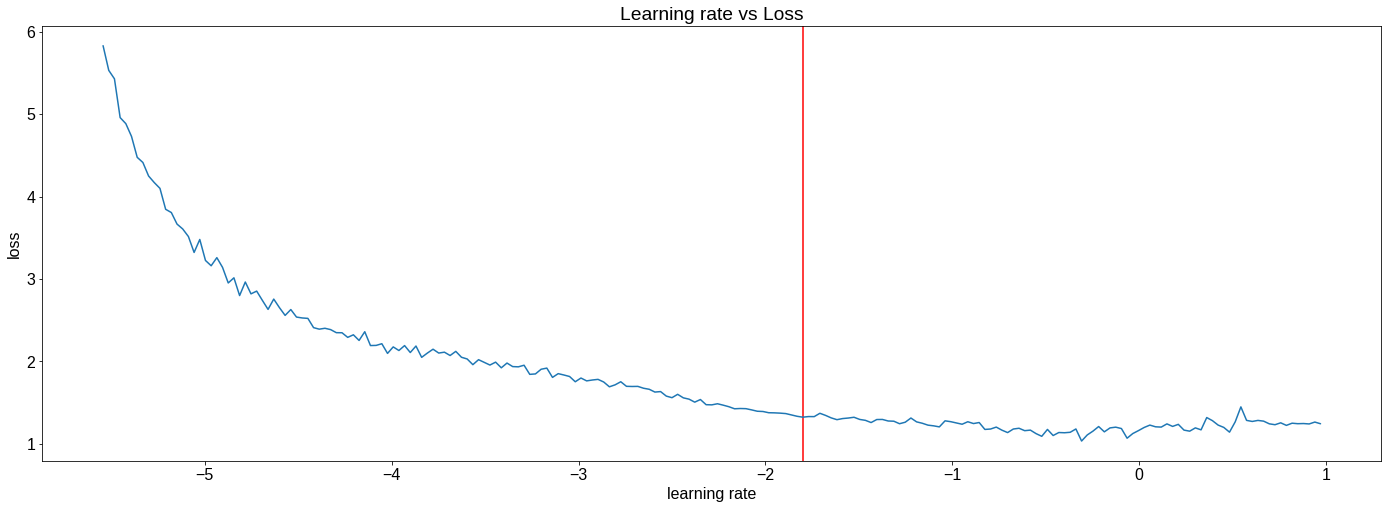

In [6]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(None, None, CHANNELS))

lr_finder = LRFinder(num_samples=len(X_train), batch_size=BATCH_SIZE, minimum_lr=1e-6, maximum_lr=10, verbose=0)
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss)

model.fit_generator(generator=train_generator_pt1, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs=1, 
                    callbacks=[lr_finder])

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(24, 8))
plt.axvline(x=np.log10(LEARNING_RATE), color='red')
lr_finder.plot_schedule(clip_beginning=15)

# Model PT 1

In [7]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(None, None, CHANNELS))

oneCycleLR = OneCycleLR(max_lr=LEARNING_RATE, maximum_momentum=0.9, minimum_momentum=0.9, 
                        epochs=EPOCHS_PT1, batch_size=BATCH_SIZE, samples=len(X_train), steps=STEP_SIZE_TRAIN)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [oneCycleLR]
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [8]:
history = model.fit_generator(generator=train_generator_pt1,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator_pt1,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS_PT1,
                              verbose=2).history

Epoch 1/5


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.568118). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 448s - loss: 1.2720 - dice_coef: 0.2135 - iou_score: 0.1172 - f1-score: 0.2085 - val_loss: 1.2934 - val_dice_coef: 0.2367 - val_iou_score: 0.1329 - val_f1-score: 0.2333
 - lr: 0.00790 - momentum: 0.90 
Epoch 2/5
 - 415s - loss: 1.1133 - dice_coef: 0.2845 - iou_score: 0.1655 - f1-score: 0.2788 - val_loss: 1.0353 - val_dice_coef: 0.3776 - val_iou_score: 0.2295 - val_f1-score: 0.3605
 - lr: 0.01425 - momentum: 0.90 
Epoch 3/5
 - 399s - loss: 0.9742 - dice_coef: 0.3893 - iou_score: 0.2475 - f1-score: 0.3876 - val_loss: 0.9505 - val_dice_coef: 0.4506 - val_iou_score: 0.2948 - val_f1-score: 0.4458
 - lr: 0.01110 - momentum: 0.90 
Epoch 4/5
 - 400s - loss: 0.9125 - dice_coef: 0.4365 - iou_score: 0.2825 - f1-score: 0.4329 - val_loss: 0.8619 - val_dice_coef: 0.4727 - val_iou_score: 0.3141 - val_f1-score: 0.4688
 - lr: 0.00476 - momentum: 0.90 
Epoch 5/5
 - 402s - loss: 0.8853 - dice_coef: 0.4532 - iou_score: 0.2968 - f1-score: 0.4503 - val_loss: 0.9779 - val_dice_coef: 0.4855 - val_iou_score

# Model

In [9]:
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
oneCycleLR = OneCycleLR(max_lr=LEARNING_RATE, maximum_momentum=0.9, minimum_momentum=0.9, 
                        epochs=EPOCHS_PT1, batch_size=BATCH_SIZE, samples=len(X_train), steps=STEP_SIZE_TRAIN)


metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, oneCycleLR]
optimizer = optimizers.SGD(lr=LEARNING_RATE, momentum=0.9, nesterov=True)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [10]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/15


/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.797569). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 526s - loss: 0.8945 - dice_coef: 0.4532 - iou_score: 0.2962 - f1-score: 0.4501 - val_loss: 0.9045 - val_dice_coef: 0.4940 - val_iou_score: 0.3233 - val_f1-score: 0.4798
 - lr: 0.00790 - momentum: 0.90 
Epoch 2/15
 - 505s - loss: 0.8892 - dice_coef: 0.4585 - iou_score: 0.2994 - f1-score: 0.4541 - val_loss: 0.7902 - val_dice_coef: 0.5025 - val_iou_score: 0.3366 - val_f1-score: 0.4961
 - lr: 0.01425 - momentum: 0.90 
Epoch 3/15
 - 523s - loss: 0.8686 - dice_coef: 0.4732 - iou_score: 0.3126 - f1-score: 0.4693 - val_loss: 0.7135 - val_dice_coef: 0.5146 - val_iou_score: 0.3386 - val_f1-score: 0.4982
 - lr: 0.01110 - momentum: 0.90 
Epoch 4/15
 - 517s - loss: 0.8484 - dice_coef: 0.4869 - iou_score: 0.3237 - f1-score: 0.4818 - val_loss: 0.8362 - val_dice_coef: 0.5272 - val_iou_score: 0.3565 - val_f1-score: 0.5176
 - lr: 0.00476 - momentum: 0.90 
Epoch 5/15
 - 515s - loss: 0.8349 - dice_coef: 0.4947 - iou_score: 0.3301 - f1-score: 0.4894 - val_loss: 0.8222 - val_dice_coef: 0.5285 - val_iou_s

## Model loss graph

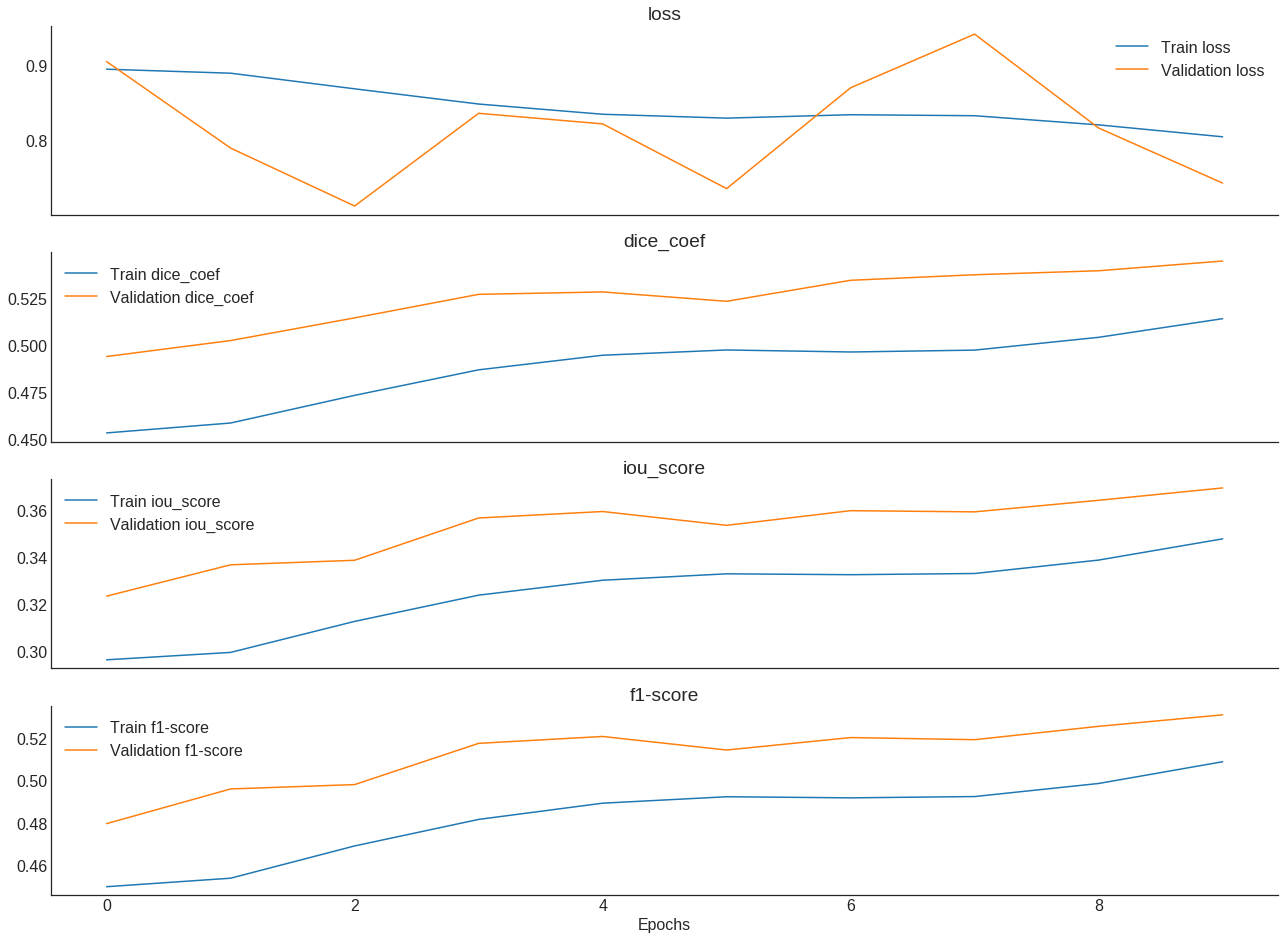

In [11]:
plot_metrics(history, metric_list=['loss', 'dice_coef', 'iou_score', 'f1-score'])